# Imports Here

In [ ]:
# Step 1: Mount Google Drive
import cv2
import json
import numpy as np
import os
import random
import re
import tensorflow as tf
import albumentations as A

from collections import Counter
from google.colab import drive
from PIL import Image
from sklearn.metrics import f1_score, precision_score, recall_score, average_precision_score, roc_auc_score, jaccard_score, hamming_loss
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50V2, InceptionV3, Xception, VGG16, MobileNetV3Large, EfficientNetB0, MobileNetV2
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
from typing import Any, Dict, List, Tuple


drive.mount('/content/drive')

Mounted at /content/drive


# Read The Files

In [ ]:
# === PATHS ===
videos_path = "/content/drive/MyDrive/Project/cholect50-challenge-val/videos"
labels_path = "/content/drive/MyDrive/Project/cholect50-challenge-val/labels"
label_map_file = "/content/drive/MyDrive/Project/cholect50-challenge-val/label_mapping.txt"

In [ ]:
verb_mapping = {}
with open(os.path.join(label_map_file), 'r') as f:
    for line in f:
        line = line.strip()
        if not line or line.startswith('#'):  # skip comments/headers
            continue
        parts = line.split(',')
        triplet_id = int(parts[0])
        verb_id = int(parts[2])  # 3rd column = verb ID (as per CholecT50 format)
        verb_mapping[triplet_id] = verb_id

X = []
Y = []

# Loop through all video folders
for vid_folder in sorted(os.listdir(videos_path)):
    vid_path = os.path.join(videos_path, vid_folder)
    if not os.path.isdir(vid_path):
        continue

    # Corresponding label JSON
    label_file = f"{vid_folder}.json"
    label_path = os.path.join(labels_path, label_file)
    if not os.path.exists(label_path):
        print(f"Warning: {label_path} not found, skipping {vid_folder}")
        continue

    # Load JSON labels
    with open(label_path, 'r') as f:
        data = json.load(f)
    annotations = data['annotations']

    # Build frame_number -> verb_id list
    frame_verb = {}
    for frame_id, triplets in annotations.items():
        frame_number = int(frame_id)
        verbs_in_frame = []

        for triplet in triplets:
            triplet_id = triplet[0]
            verb_id = verb_mapping.get(triplet_id, -1)
            if verb_id != -1:
                verbs_in_frame.append(verb_id)

        # Only store frames that have at least one valid verb
        if len(verbs_in_frame) > 0:
            frame_verb[frame_number] = verbs_in_frame

    # Process frames in this video
    frame_files = sorted([f for f in os.listdir(vid_path) if f.endswith('.png')])
    for frame_file in frame_files:
        match = re.match(r"(\d+)", frame_file)
        if not match:
            continue
        frame_number = int(match.group(1))

        # Skip frames without a verb
        if frame_number not in frame_verb:
            continue

        verb_id = frame_verb[frame_number][0]  # use first verb if multiple

        # Load image
        img_path = os.path.join(vid_path, frame_file)
        img = cv2.imread(img_path)
        if img is None:
            continue

        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        X.append(img)
        Y.append(verb_id)

# Convert to numpy arrays
X = np.array(X, dtype=np.float32) / 255.0
Y = np.array(Y, dtype=np.int64)

print(f"✅ Total frames processed: {len(X)}")
print(f"X shape: {X.shape}, Y shape: {Y.shape}")
print(f"Unique verbs/actions (set(Y)):", sorted(set(Y)))

✅ Total frames processed: 1209
X shape: (1209, 224, 224, 3), Y shape: (1209,)
Unique verbs/actions (set(Y)): [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(9)]


In [ ]:
import cv2
import numpy as np
from collections import Counter
import albumentations as A

print("Original class distribution:")
print(Counter(Y))

unique, counts = np.unique(Y, return_counts=True)
max_count = np.max(counts)
upsample_limit = 200

aug_pipeline = A.Compose([
    A.RandomCrop(width=200, height=200, p=1.0),   # crop
    A.Rotate(limit=30, p=1.0)                     # rotate
])

X_balanced = []
Y_balanced = []

for cls in unique:
    cls_indices = np.where(Y == cls)[0]
    X_cls = X[cls_indices]
    Y_cls = Y[cls_indices]

    X_balanced.extend(X_cls)
    Y_balanced.extend(Y_cls)

    n_samples_needed = min(max_count - len(X_cls), upsample_limit)

    for _ in range(n_samples_needed):
        idx = np.random.randint(0, len(X_cls))
        img = X_cls[idx]
        img_aug = aug_pipeline(image=img)['image']

        # Resize back to 224x224
        img_aug_resized = cv2.resize(img_aug, (224, 224))

        X_balanced.append(img_aug_resized)
        Y_balanced.append(cls)

X_balanced = np.array(X_balanced, dtype=np.float32)
Y_balanced = np.array(Y_balanced, dtype=np.int64)

Original class distribution:
Counter({np.int64(1): 265, np.int64(0): 218, np.int64(3): 160, np.int64(2): 128, np.int64(4): 108, np.int64(5): 104, np.int64(6): 98, np.int64(9): 70, np.int64(7): 58})


In [ ]:
# Original labels
unique_labels = sorted(np.unique(Y_balanced))  # [0,1,2,3,4,5,6,7,9]
label_map = {old:i for i, old in enumerate(unique_labels)}
print("Label mapping:", label_map)

# Apply mapping
Y_balanced_mapped = np.array([label_map[y] for y in Y_balanced])

# Now labels are continuous 0..8
num_classes = len(unique_labels)

Label mapping: {np.int64(0): 0, np.int64(1): 1, np.int64(2): 2, np.int64(3): 3, np.int64(4): 4, np.int64(5): 5, np.int64(6): 6, np.int64(7): 7, np.int64(9): 8}


In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

X_train, X_temp, Y_train, Y_temp = train_test_split(
    X_balanced, Y_balanced_mapped, test_size=0.3, stratify=Y_balanced_mapped, random_state=42
)
X_val, X_test, Y_val, Y_test = train_test_split(
    X_temp, Y_temp, test_size=0.5, stratify=Y_temp, random_state=42
)

# Convert labels to one-hot encoding
Y_train_one_hot = tf.keras.utils.to_categorical(Y_train, num_classes=num_classes)
Y_val_one_hot = tf.keras.utils.to_categorical(Y_val, num_classes=num_classes)
Y_test_one_hot = tf.keras.utils.to_categorical(Y_test, num_classes=num_classes)

In [ ]:
BATCH_SIZE = 128
AUTOTUNE = tf.data.AUTOTUNE

def make_dataset(X, Y, batch_size=BATCH_SIZE, training=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    if training:
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size).prefetch(AUTOTUNE)
    return dataset

train_ds = make_dataset(X_train, Y_train_one_hot, training=True)
val_ds   = make_dataset(X_val, Y_val_one_hot, training=False)
test_ds  = make_dataset(X_test, Y_test_one_hot, training=False)

In [ ]:
del X_train, X_val, X_test, Y_train, Y_val, Y_test, Y_balanced_mapped
del Y_train_one_hot, Y_val_one_hot, Y_test_one_hot # Also delete the one-hot encoded labels

In [ ]:
IMG_SIZE = 224
drop_rate = 0.3
num_heads = 4  # multihead attention heads
embed_dim = 128  # feature dimension for attention
num_instruments = 6 # Assuming 6 instruments based on previous output
epoch_size = 20

def build_model_with_backbone(backbone_model, input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=9):
    """
    Builds a model with a specified backbone, Multi-Head Attention, and dense layers.

    Args:
        backbone_model: The Keras application model class (e.g., MobileNetV2, ResNet50V2).
        input_shape: The input shape of the images.
        num_classes: The number of output classes.

    Returns:
        A Keras Model.
    """
    # === Backbone ===
    # Ensure include_top is False to get the convolutional base
    # Handle potential differences in input_shape argument name
    try:
        base = backbone_model(include_top=False, weights='imagenet', input_shape=input_shape, pooling=None)
    except TypeError:
         base = backbone_model(include_top=False, weights='imagenet', input_shape=input_shape) # Some models don't have pooling arg


    base.trainable = False  # Freeze backbone initially

    inp = layers.Input(shape=input_shape)
    x = base(inp)

    # Flatten spatial dimensions for attention: (batch, seq_len, channels)
    # Handle cases where base output might be flattened already or have different ranks
    if len(x.shape) == 4:
        b, h, w, c = x.shape
        x_flat = layers.Reshape((-1, c))(x)  # seq_len = h*w
    elif len(x.shape) == 3:
         x_flat = x # Assume already (batch, seq_len, channels)
    else:
         raise ValueError(f"Unexpected backbone output shape: {x.shape}")


    # === Multi-Head Attention ===
    # Adjust key_dim if embed_dim is larger than backbone channels
    attention_key_dim = min(embed_dim, x_flat.shape[-1])
    attn_out = layers.MultiHeadAttention(num_heads=num_heads, key_dim=attention_key_dim)(x_flat, x_flat)
    attn_out = layers.GlobalAveragePooling1D()(attn_out)

    # === Dense Head ===
    x = layers.Dropout(drop_rate)(attn_out)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(drop_rate)(x)
    out = layers.Dense(num_classes, activation='sigmoid')(x)  # multi-label output

    model = models.Model(inputs=inp, outputs=out)
    return model

# Example usage:
# model_resnet = build_model_with_backbone(ResNet50V2)
# model_inception = build_model_with_backbone(InceptionV3)
# model_xception = build_model_with_backbone(Xception)
# model_vgg16 = build_model_with_backbone(VGG16)
# model_mobilenetv3 = build_model_with_backbone(MobileNetV3Large)
# model_efficientnet = build_model_with_backbone(EfficientNetB0)

print("Functions to build models with different backbones created.")

Functions to build models with different backbones created.


In [ ]:
from sklearn.metrics import precision_recall_curve

def calculate_multi_label_metrics(model: Any, val_ds: Any) -> Dict[str, Any]:
    """
    Calculates multi-label metrics with automatic per-class threshold optimization.
    """

    print("Collecting true labels and generating predictions...")
    y_true = np.concatenate([y for _, y in val_ds], axis=0)
    y_probs = np.concatenate([model.predict(x) for x, _ in val_ds], axis=0)

    num_classes = y_true.shape[1]

    # ----------------------------
    # Per-class threshold optimization (maximize F1)
    # ----------------------------
    optimal_thresholds = []
    for i in range(num_classes):
        precision, recall, thresh = precision_recall_curve(y_true[:, i], y_probs[:, i])
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
        best_index = np.argmax(f1_scores)
        # Edge case: threshold array is shorter by one compared to precision/recall
        if best_index >= len(thresh):
            best_index = len(thresh) - 1
        best_thresh = thresh[best_index]
        optimal_thresholds.append(best_thresh)

    print("\n🎯 Per-Class Optimal Thresholds:")
    for i, t in enumerate(optimal_thresholds):
        print(f" Class {i}: {t:.3f}")

    # Apply optimized thresholds
    y_pred = np.zeros_like(y_probs)
    for i in range(num_classes):
        y_pred[:, i] = (y_probs[:, i] >= optimal_thresholds[i]).astype(int)

    print(f"\n🔢 Total Positives After Thresholding: {y_pred.sum()}")

    # ----------------------------
    # Micro metrics
    # ----------------------------
    precision_micro = precision_score(y_true, y_pred, average='micro', zero_division=0)
    recall_micro = recall_score(y_true, y_pred, average='micro', zero_division=0)
    f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)

    # ----------------------------
    # Macro metrics
    # ----------------------------
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)

    # ----------------------------
    # Per-class probability metrics
    # ----------------------------
    avg_precision = [average_precision_score(y_true[:, i], y_probs[:, i]) for i in range(num_classes)]
    roc_auc = [roc_auc_score(y_true[:, i], y_probs[:, i]) for i in range(num_classes)]

    # ----------------------------
    # Multi-label specific metrics
    # ----------------------------
    jaccard_micro = jaccard_score(y_true, y_pred, average='micro', zero_division=0)
    jaccard_macro = jaccard_score(y_true, y_pred, average='macro', zero_division=0)
    hamming = hamming_loss(y_true, y_pred)

    # ----------------------------
    # Print results
    # ----------------------------
    print("\n=== Multi-label metrics (Optimized Thresholds) ===")
    print(f"Precision micro: {precision_micro:.4f}, Recall micro: {recall_micro:.4f}, F1 micro: {f1_micro:.4f}")
    print(f"Precision macro: {precision_macro:.4f}, Recall macro: {recall_macro:.4f}, F1 macro: {f1_macro:.4f}")
    print(f"Jaccard index (micro): {jaccard_micro:.4f}, Jaccard index (macro): {jaccard_macro:.4f}")
    print(f"Hamming loss: {hamming:.4f}")
    print("Average precision per class:", np.round(avg_precision, 3))
    print("ROC-AUC per class:", np.round(roc_auc, 3))

    return {
        'optimal_thresholds': optimal_thresholds,
        'precision_micro': precision_micro,
        'recall_micro': recall_micro,
        'f1_micro': f1_micro,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'jaccard_micro': jaccard_micro,
        'jaccard_macro': jaccard_macro,
        'hamming_loss': hamming,
        'avg_precision_per_class': avg_precision,
        'roc_auc_per_class': roc_auc,
        'total_positives_after_thresholding': int(y_pred.sum()) # Adding total positives
    }

In [ ]:
model = build_model_with_backbone(MobileNetV2)
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 7, 7,      │  2,257,984 │ input_layer_1[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 49, 1280)  │          0 │ mobilenetv2_1.00… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 49, 1280)  │  2,624,256 │ reshape[0][0],    │
│ (MultiHeadAttentio… │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ multi_head_atten… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1280)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    163,968 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 9)         │      1,161 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,047,369 (19.25 MB)

 Trainable params: 2,789,385 (10.64 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
model_backbones = ['ResNet50V2', 'InceptionV3', 'Xception', 'VGG16', 'MobileNetV3Large', 'EfficientNetB0', 'MobileNetV2']
# model_backbones = ['MobileNetV2']

In [ ]:
import pandas as pd

# List to store evaluation results for each model
all_results = []

# Iterate through the list of model backbones
for backbone_name in model_backbones:
    print(f"\n--- Processing Model: {backbone_name} ---")

    # Step 3: Build model
    print("Building model...")
    try:
        backbone_class = globals()[backbone_name]
        model = build_model_with_backbone(backbone_class, num_classes=num_classes) # Pass the correct num_classes
        print(f"Model {backbone_name} built successfully.")
        # model.summary() # Optional: Print summary

        # Extract trainable parameters (in millions)
        trainable_params = model.count_params() / 1_000_000.0
        print(f"Trainable parameters: {trainable_params:.2f}M")

    except Exception as e:
        print(f"Error building model {backbone_name}: {e}")
        continue  # Skip to the next backbone

    # Step 4: Compile model
    print("Compiling model...")
    try:
        # Use BinaryCrossentropy for multi-label classification
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss='binary_crossentropy', # Changed loss to binary_crossentropy
            metrics=[tf.keras.metrics.AUC(curve='PR', name='pr_auc')] # Removed multi_label=True
        )
        print("Model compiled successfully.")
    except Exception as e:
        print(f"Error compiling model {backbone_name}: {e}")
        del model # Free up memory
        continue # Skip to the next backbone


    # Step 5: Train model
    print("Training model...")
    try:
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epoch_size,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
                tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
            ],
            verbose=0 # Suppress verbose output during loop
        )
        print(f"Model {backbone_name} trained successfully.")
    except Exception as e:
        print(f"Error training model {backbone_name}: {e}")
        del model # Free up memory
        continue # Skip to the next backbone


    # Step 6: Evaluate model and collect results
    print("Evaluating model on test set...")
    try:
        test_results = calculate_multi_label_metrics(model, test_ds)
        print(f"\n--- Evaluation Results for {backbone_name} ---")

        # Add model name and trainable parameters to the results dictionary
        test_results['Model'] = backbone_name
        test_results['Trainable Params (M)'] = trainable_params

        # Append results to the list
        all_results.append(test_results)

        # Step 7: Save the trained model
        model_save_path = f"/content/drive/MyDrive/Project/surgical_action_recognition_model_{backbone_name}.keras"
        model.save(model_save_path)
        print(f"Model saved to: {model_save_path}")

    except Exception as e:
        print(f"Error evaluating model {backbone_name}: {e}")


    # Clean up for the next iteration to free up memory
    del model
    tf.keras.backend.clear_session()
    print(f"Finished processing {backbone_name}. Memory cleared.")

print("\n--- All models processed. ---")

# Convert results to DataFrame and save to CSV
if all_results:
    results_df = pd.DataFrame(all_results)

    # Define the path to save the CSV
    results_csv_path = "/content/drive/MyDrive/Project/surgical_action_recognition_model_evaluation_results.csv"

    try:
        results_df.to_csv(results_csv_path, index=False)
        print(f"\n✅ Evaluation results saved to: {results_csv_path}")
        display(results_df) # Display the DataFrame
    except Exception as e:
        print(f"\nError saving results to CSV: {e}")
else:
    print("\nNo results to save.")


--- Processing Model: ResNet50V2 ---
Building model...
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Model ResNet50V2 built successfully.
Trainable parameters: 28.03M
Compiling model...
Model compiled successfully.
Training model...
Model ResNet50V2 trained successfully.
Evaluating model on test set...
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step

🎯 Per-Class Optimal Thresholds:
 Class 0: 0.154
 Class 1: 0.229
 Class 2: 0.472
 Class 3: 0.300
 Class 4: 0.520
 Class 5: 0.380
 Class 6: 0.272
 Class 7: 0.136
 Class 8: 0.376

🔢 Total Positives After Thresholding: 375.0

=== Multi-label metrics (Optimized Thresholds) ===
Precision micro: 0.8027, Recall micro: 0.8431, F1 micro: 0.8224
Precision macro: 0.8067, Recall macro: 0.8429, F1 macro: 0.8189
Jaccard index (micro): 0.6984, Jaccard index (macro): 0.6994
Hamming loss: 0.0405
Average precision per class: [0.928 0.709 0.856 0.971 0.832 0.921 0.819 0.783 0.801]
ROC-AUC p

,optimal_thresholds,precision_micro,recall_micro,f1_micro,precision_macro,recall_macro,f1_macro,jaccard_micro,jaccard_macro,hamming_loss,avg_precision_per_class,roc_auc_per_class,total_positives_after_thresholding,Model,Trainable Params (M)
0,"[0.15432005, 0.228628, 0.47152498, 0.30009753,...",0.802667,0.843137,0.822404,0.806714,0.842941,0.818898,0.698376,0.699376,0.040461,"[0.9284352554223116, 0.70891279930295, 0.85607...","[0.9893533123028391, 0.9058216416706983, 0.981...",375,ResNet50V2,28.026121
1,"[0.3020351, 0.4040411, 0.48303834, 0.16234061,...",0.772251,0.826331,0.798376,0.783104,0.826559,0.799490,0.664414,0.671153,0.046374,"[0.9380111065890948, 0.7549172099585576, 0.792...","[0.9851735015772871, 0.9258184163844541, 0.947...",382,InceptionV3,26.264105
2,"[0.6632652, 0.60675645, 0.18483695, 0.24359286...",0.785326,0.809524,0.797241,0.788063,0.809315,0.793126,0.662844,0.664909,0.045752,"[0.934614047715906, 0.7021041104417404, 0.8397...","[0.9876971608832807, 0.8922754394452507, 0.975...",368,Xception,25.322801
3,"[0.21446948, 0.15045665, 0.25270575, 0.2474801...",0.413793,0.605042,0.491468,0.457724,0.605301,0.507788,0.325792,0.352430,0.139122,"[0.517148178000494, 0.29659387437422496, 0.447...","[0.8807570977917981, 0.756652152878568, 0.8187...",522,VGG16,15.832137
4,"[0.110216506, 0.10801512, 0.12986764, 0.251593...",0.178603,0.565826,0.271505,0.263260,0.566524,0.301663,0.157076,0.180575,0.337379,"[0.22565649912101143, 0.0888912807952823, 0.13...","[0.5806782334384858, 0.417029511369134, 0.5763...",1131,MobileNetV3Large,5.089097
5,"[0.109250955, 0.117205344, 0.111713596, 0.1093...",0.137772,0.834734,0.236508,0.169277,0.833502,0.266311,0.134113,0.156694,0.598817,"[0.10662090076031802, 0.10929512284094761, 0.0...","[0.49305993690851735, 0.4945976455410417, 0.32...",2163,EfficientNetB0,6.838956
6,"[0.5485543, 0.4536007, 0.50585693, 0.22307652,...",0.821326,0.798319,0.809659,0.842765,0.798932,0.806816,0.680191,0.682749,0.041706,"[0.9301624928312012, 0.7506107952608023, 0.907...","[0.9925078864353312, 0.9471053055958717, 0.984...",347,MobileNetV2,5.047369


✅ Evaluation results loaded from: /content/drive/MyDrive/Project/surgical_action_recognition_model_evaluation_results.csv
Index(['optimal_thresholds', 'precision_micro', 'recall_micro', 'f1_micro',
       'precision_macro', 'recall_macro', 'f1_macro', 'jaccard_micro',
       'jaccard_macro', 'hamming_loss', 'avg_precision_per_class',
       'roc_auc_per_class', 'total_positives_after_thresholding', 'Model',
       'Trainable Params (M)'],
      dtype='object')


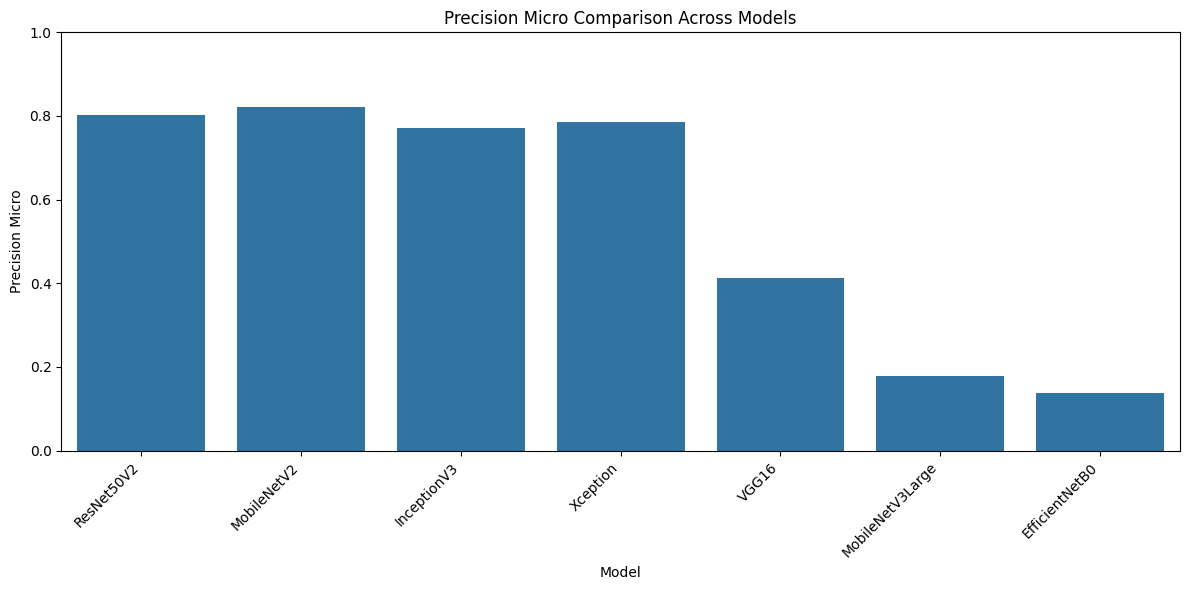

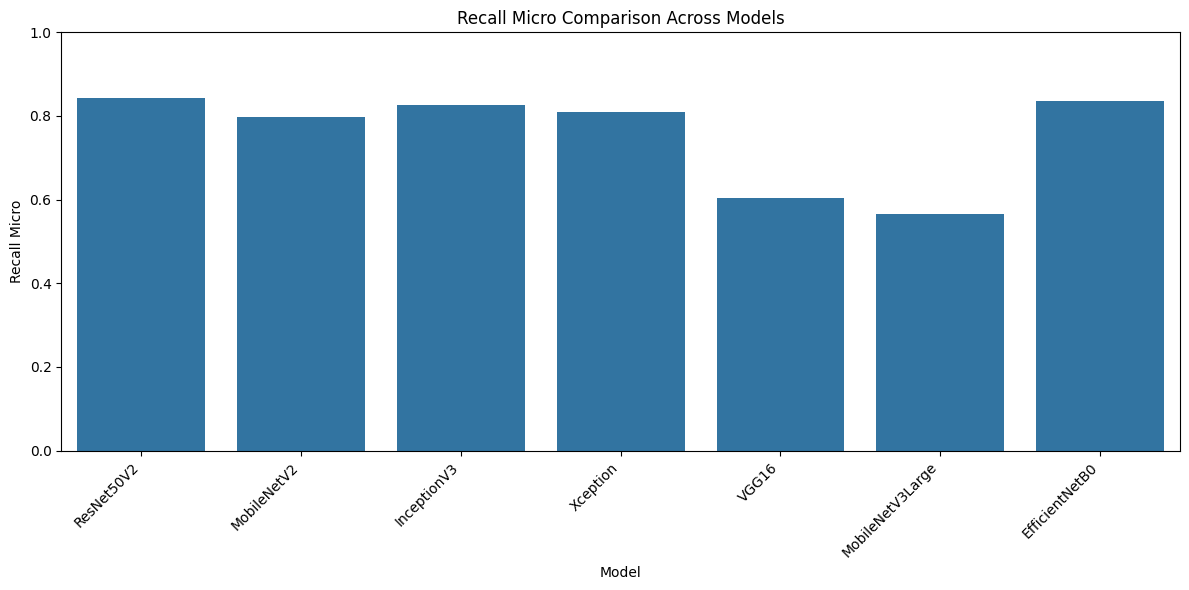

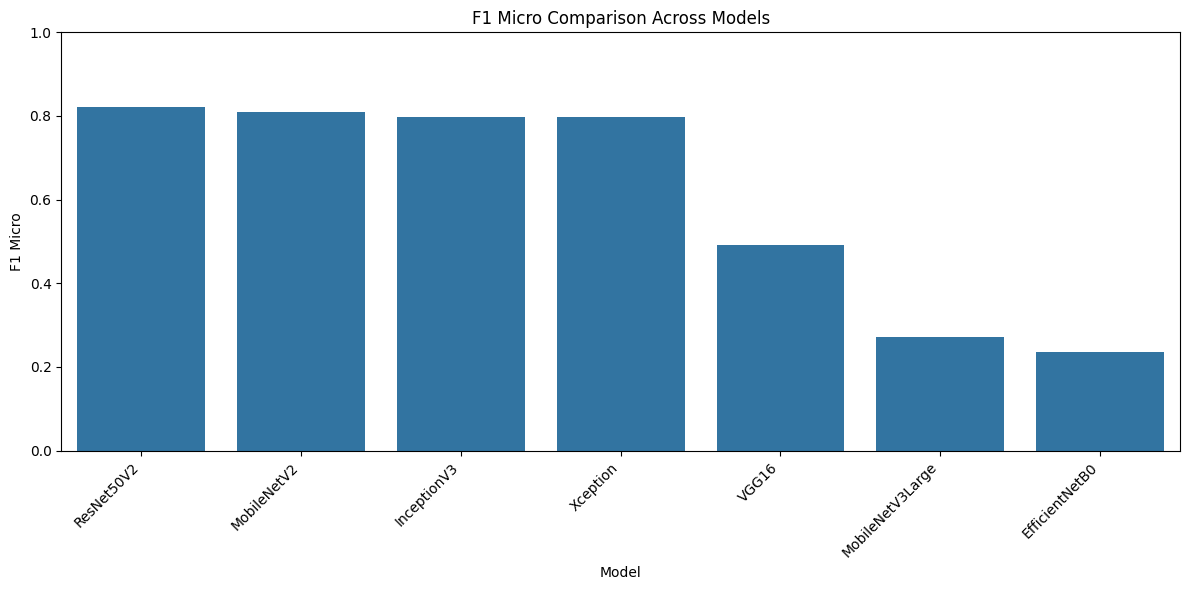

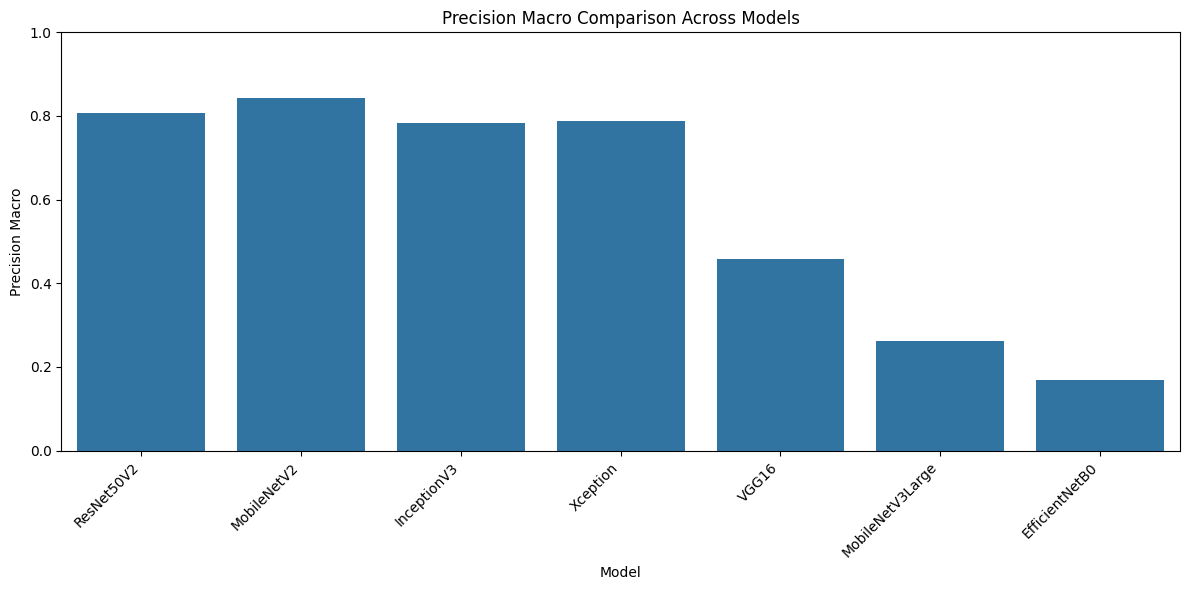

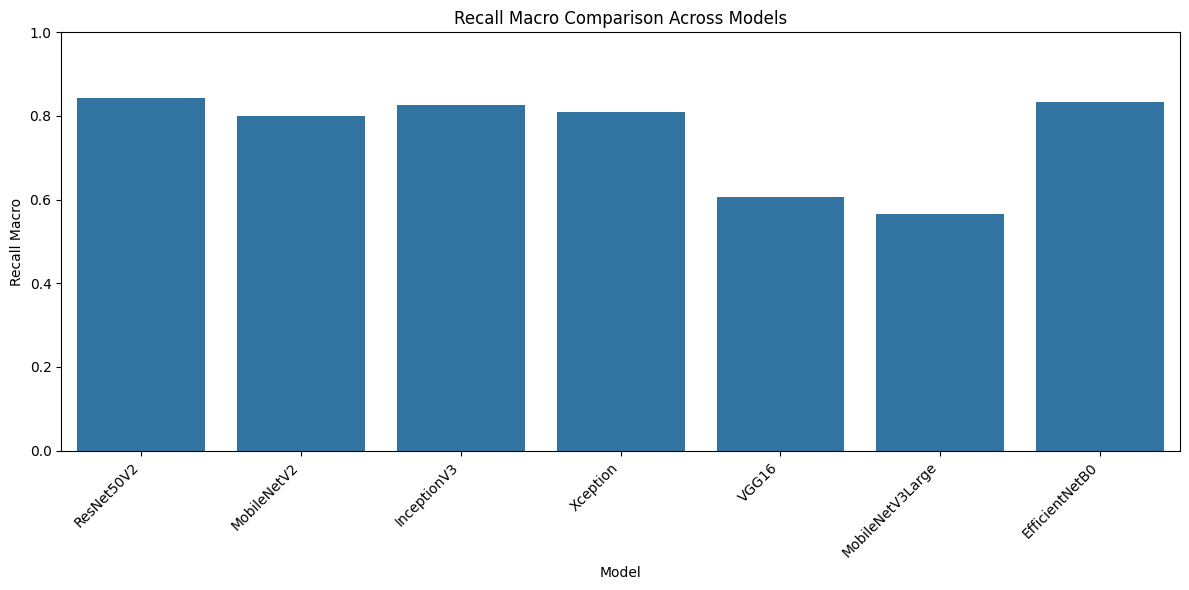

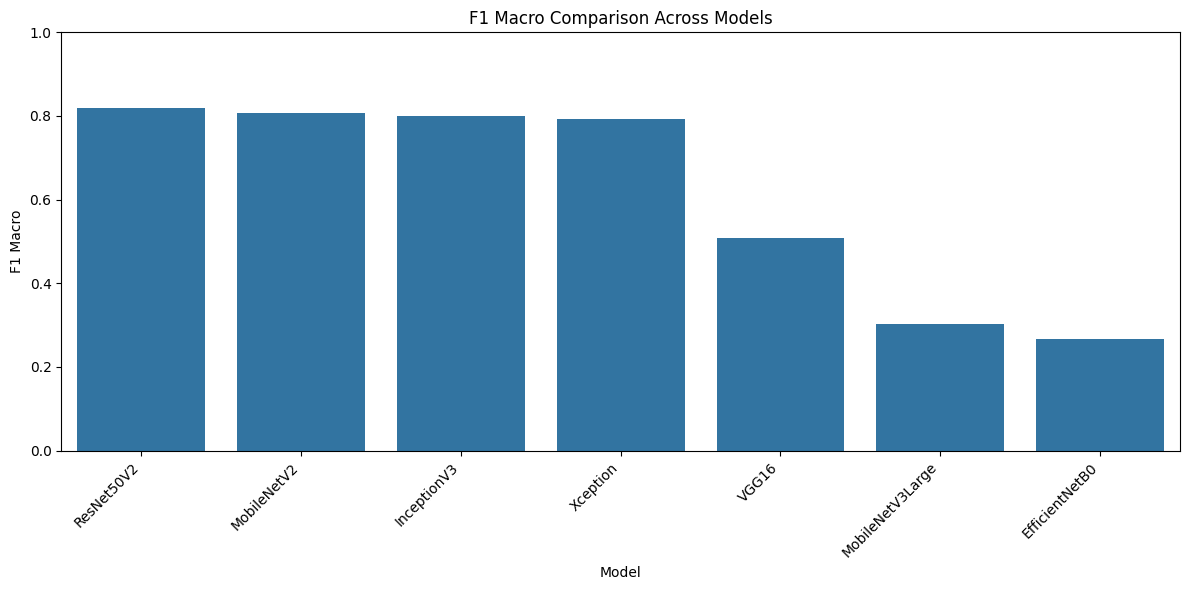

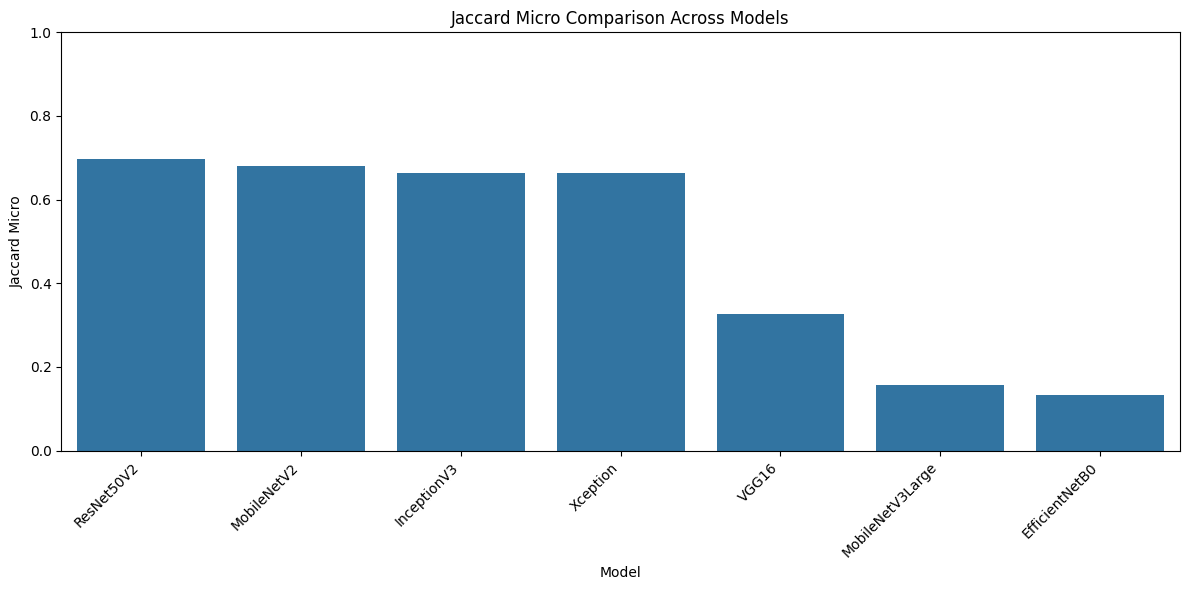

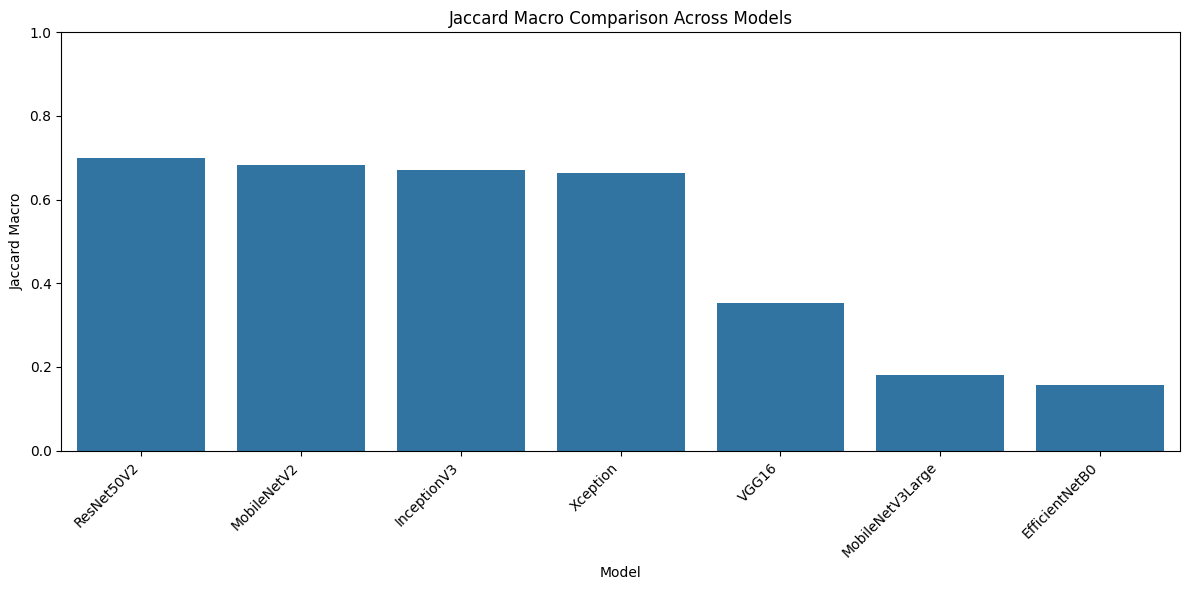

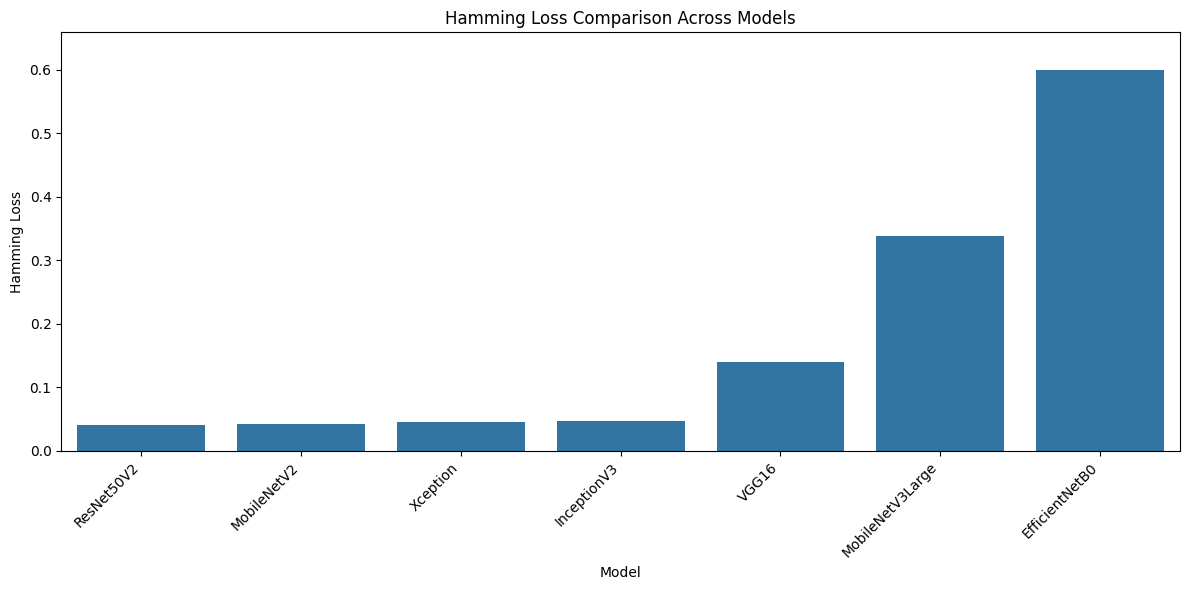

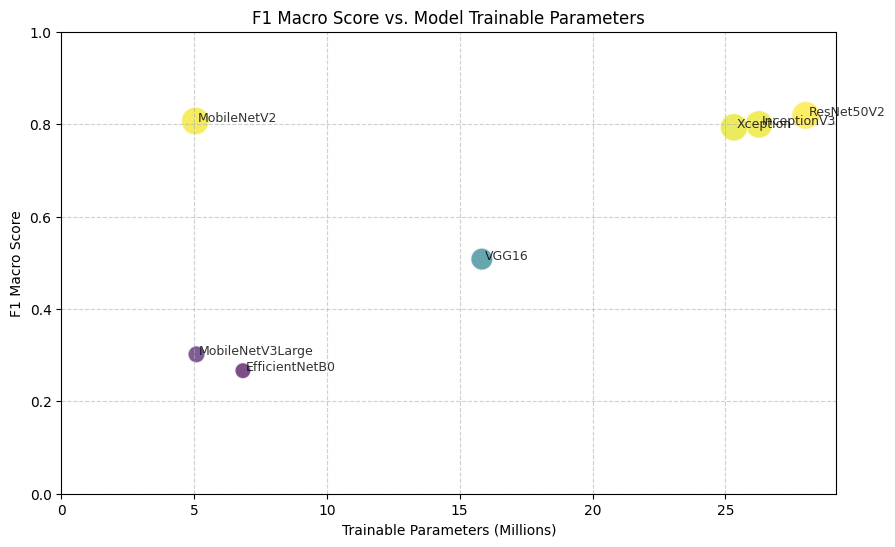

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Define the path to the CSV file
results_csv_path = "/content/drive/MyDrive/Project/surgical_action_recognition_model_evaluation_results.csv"

try:
    # Read the data from the CSV file
    df = pd.read_csv(results_csv_path)
    print(f"✅ Evaluation results loaded from: {results_csv_path}")
    print(df.columns)
except FileNotFoundError:
    print(f"Error: The file '{results_csv_path}' was not found.")
    # Handle the error, maybe skip plotting or use placeholder data
    df = pd.DataFrame() # Create an empty DataFrame to avoid errors later
except Exception as e:
    print(f"Error reading CSV file: {e}")
    df = pd.DataFrame() # Create an empty DataFrame to avoid errors later


if not df.empty:
    # Sort by f1_macro for better visualization in the first plot
    df_sorted = df.sort_values(by='f1_macro', ascending=False)

    # ----------------------------------------------------------------------
    ## Plotting available metrics
    # ----------------------------------------------------------------------

    metrics_to_plot = ['precision_micro', 'recall_micro', 'f1_micro', 'precision_macro', 'recall_macro', 'f1_macro', 'jaccard_micro', 'jaccard_macro', 'hamming_loss'] # Removed weighted metrics and accuracy

    for metric in metrics_to_plot:
        plt.figure(figsize=(12, 6))
        # For hamming_loss, lower is better, so we might want to invert the sorting or handle it separately if plotting on the same scale
        if metric == 'hamming_loss':
             sns.barplot(x='Model', y=metric, data=df_sorted.sort_values(by=metric, ascending=True)) # Sort ascending for hamming loss plot
        else:
             sns.barplot(x='Model', y=metric, data=df_sorted)

        plt.title(f'{metric.replace("_", " ").title()} Comparison Across Models')
        plt.xlabel('Model')
        plt.ylabel(metric.replace("_", " ").title())
        plt.xticks(rotation=45, ha='right')
        # Adjust y-axis limit based on metric
        if metric == 'hamming_loss':
            plt.ylim(0, max(df_sorted[metric])*1.1) # Set upper limit slightly above max hamming loss
        else:
            plt.ylim(0, 1.0) # Assuming most metrics are between 0 and 1
        plt.tight_layout()
        plt.show()

    # ----------------------------------------------------------------------
    ## Scatter plot of F1 Macro vs. Trainable Parameters
    # ----------------------------------------------------------------------

    plt.figure(figsize=(10, 6))
    plt.scatter(
        df['Trainable Params (M)'], # Use the correct column name
        df['f1_macro'], # Use f1_macro instead of f1_weighted
        s=df['f1_macro'] * 500,  # Size based on F1 macro
        c=df['f1_macro'],        # Color based on F1 macro
        cmap='viridis',
        alpha=0.7,
        edgecolors='w',
        linewidths=1
    )

    # Annotate each point with the model name
    for i, row in df.iterrows():
        plt.annotate(
            row['Model'], # Use the correct column name
            (row['Trainable Params (M)'] + 0.1, row['f1_macro']), # Adjust annotation position
            fontsize=9,
            alpha=0.8
        )

    plt.xlabel('Trainable Parameters (Millions)')
    plt.ylabel('F1 Macro Score')
    plt.title('F1 Macro Score vs. Model Trainable Parameters')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim(0)
    plt.ylim(0, 1.0)

    plt.savefig('model_efficiency_tradeoff.png')
    plt.show()
    plt.close()

else:
    print("DataFrame is empty. Cannot generate plots.")

✅ Evaluation results loaded from: /content/drive/MyDrive/Project/surgical_action_recognition_model_evaluation_results.csv


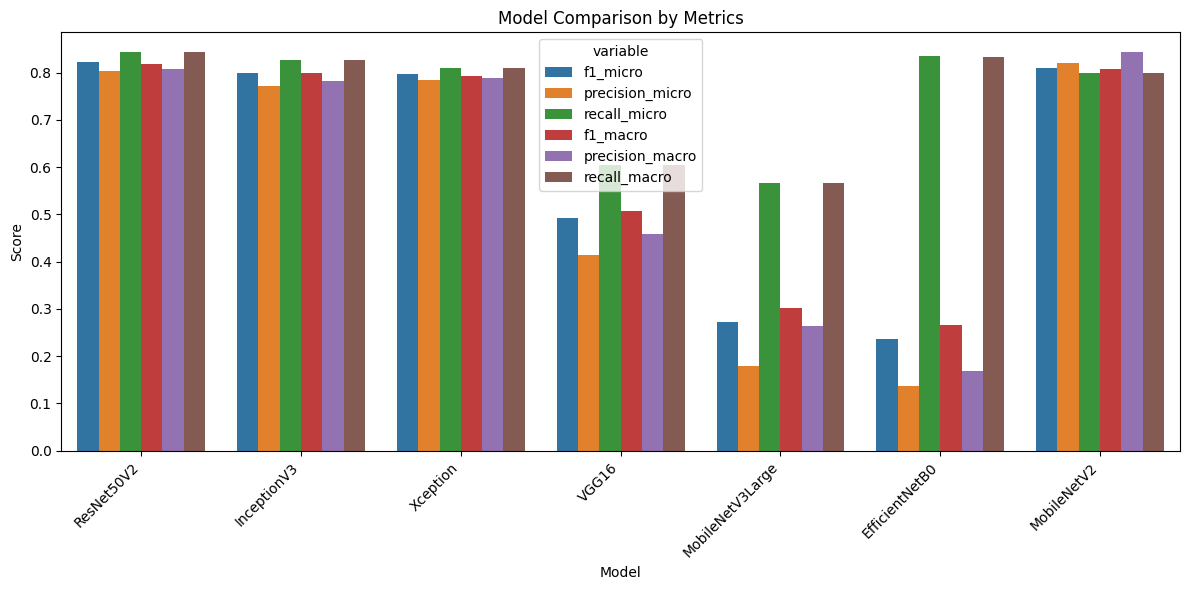

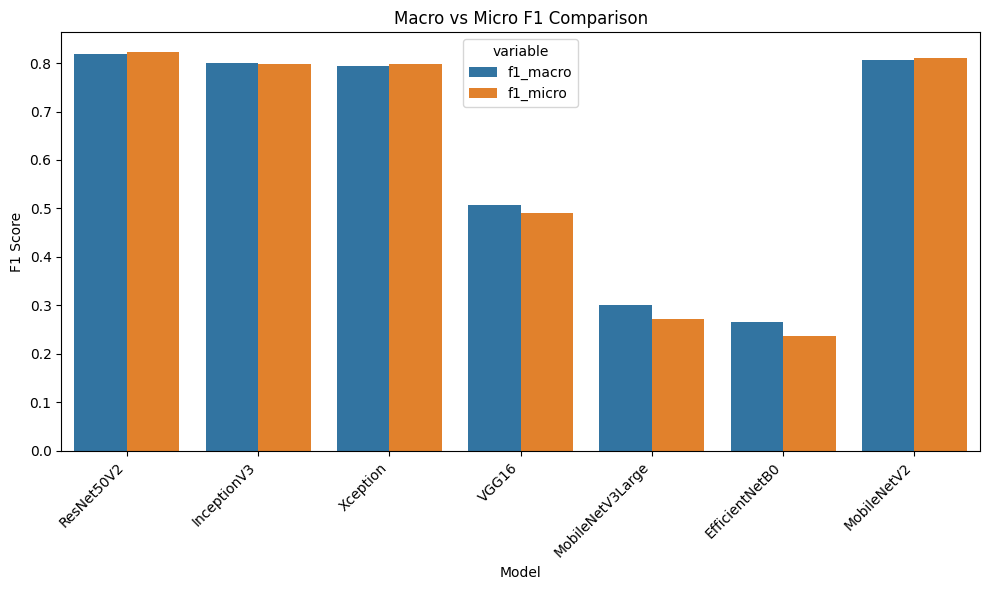

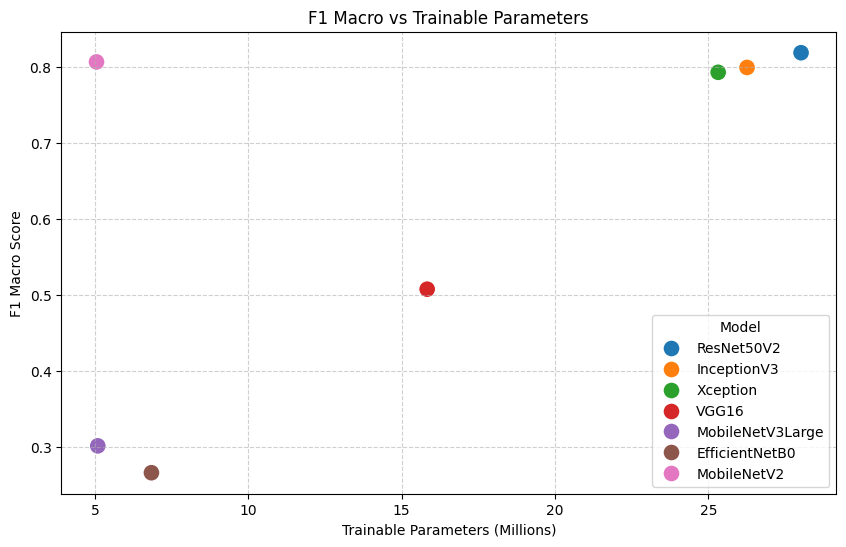

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Define the path to the CSV file
results_csv_path = "/content/drive/MyDrive/Project/surgical_action_recognition_model_evaluation_results.csv"

try:
    # Read the data from the CSV file
    df = pd.read_csv(results_csv_path)
    print(f"✅ Evaluation results loaded from: {results_csv_path}")
except FileNotFoundError:
    print(f"Error: The file '{results_csv_path}' was not found.")
    # Handle the error, maybe skip plotting or use placeholder data
    df = pd.DataFrame() # Create an empty DataFrame to avoid errors later
except Exception as e:
    print(f"Error reading CSV file: {e}")
    df = pd.DataFrame() # Create an empty DataFrame to avoid errors later


if not df.empty:
  # Assuming you have a DataFrame `df`
  metrics = ['f1_micro', 'precision_micro', 'recall_micro', 'f1_macro', 'precision_macro', 'recall_macro'] # Updated metrics list

  plt.figure(figsize=(12,6)) # Increased figure size
  sns.barplot(data=df.melt(id_vars='Model', value_vars=metrics), # Corrected 'model' to 'Model'
              x='Model', y='value', hue='variable') # Corrected 'model' to 'Model'
  plt.title("Model Comparison by Metrics")
  plt.xticks(rotation=45, ha='right') # Rotated and aligned x-axis labels
  plt.ylabel("Score")
  plt.tight_layout() # Adjusted layout
  plt.show()

  # Compare f1_macro and f1_micro
  metrics_compare = ['f1_macro', 'f1_micro'] # Corrected 'f1_weighted' to 'f1_micro'

  plt.figure(figsize=(10,6)) # Added figure
  sns.barplot(data=df.melt(id_vars='Model', value_vars=metrics_compare), # Corrected 'model' to 'Model'
              x='Model', y='value', hue='variable') # Corrected 'model' to 'Model'
  plt.title("Macro vs Micro F1 Comparison") # Updated title
  plt.xticks(rotation=45, ha='right') # Rotated and aligned x-axis labels
  plt.ylabel("F1 Score") # Updated y-label
  plt.tight_layout() # Adjusted layout
  plt.show()

  # Scatter plot of F1 Macro vs. Trainable Parameters
  plt.figure(figsize=(10,6))
  sns.scatterplot(data=df, x='Trainable Params (M)', y='f1_macro', hue='Model', s=150) # Corrected column names and hue
  # plt.xscale('log') # Removed log scale as values are not extremely large
  plt.title("F1 Macro vs Trainable Parameters") # Updated title
  plt.xlabel("Trainable Parameters (Millions)") # Updated x-label
  plt.ylabel("F1 Macro Score") # Updated y-label
  plt.grid(True, linestyle='--', alpha=0.6) # Added grid
  plt.show()

  # Removed the heatmap code as 'classification_report' column is not available.

else:
    print("DataFrame is empty. Cannot generate plots.")